In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Data loading and transformation

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:09<00:00, 1066574.79it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 58072.70it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1266647.47it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4502606.66it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Define Encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(128 * 4 * 4, 12)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(12,32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, Encoder):
        super(CombinedModel, self).__init__()
        self.encoder = Encoder
        self.classifier = Classifier()

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

In [ ]:
ourEncoder = Encoder()

In [ ]:
# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CombinedModel(ourEncoder).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Training loop
num_epochs = 16
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on test set
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100. * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')


100%|██████████| 157/157 [00:01<00:00, 126.42it/s]


Epoch [1/16], Train Loss: 0.6523, Train Acc: 79.87%, Test Loss: 0.2650, Test Acc: 92.01%


100%|██████████| 157/157 [00:01<00:00, 125.71it/s]


Epoch [2/16], Train Loss: 0.2139, Train Acc: 93.64%, Test Loss: 0.1543, Test Acc: 95.32%


100%|██████████| 157/157 [00:01<00:00, 130.75it/s]


Epoch [3/16], Train Loss: 0.1477, Train Acc: 95.67%, Test Loss: 0.1126, Test Acc: 96.63%


100%|██████████| 157/157 [00:01<00:00, 129.62it/s]


Epoch [4/16], Train Loss: 0.1137, Train Acc: 96.67%, Test Loss: 0.0912, Test Acc: 97.09%


100%|██████████| 157/157 [00:01<00:00, 129.86it/s]


Epoch [5/16], Train Loss: 0.0941, Train Acc: 97.26%, Test Loss: 0.0776, Test Acc: 97.78%


100%|██████████| 157/157 [00:01<00:00, 128.88it/s]


Epoch [6/16], Train Loss: 0.0803, Train Acc: 97.59%, Test Loss: 0.0689, Test Acc: 97.87%


100%|██████████| 157/157 [00:01<00:00, 126.85it/s]


Epoch [7/16], Train Loss: 0.0706, Train Acc: 97.90%, Test Loss: 0.0621, Test Acc: 98.02%


100%|██████████| 157/157 [00:01<00:00, 130.56it/s]


Epoch [8/16], Train Loss: 0.0615, Train Acc: 98.12%, Test Loss: 0.0548, Test Acc: 98.27%


100%|██████████| 157/157 [00:01<00:00, 89.40it/s] 


Epoch [9/16], Train Loss: 0.0545, Train Acc: 98.36%, Test Loss: 0.0547, Test Acc: 98.26%


100%|██████████| 157/157 [00:01<00:00, 83.13it/s] 


Epoch [10/16], Train Loss: 0.0494, Train Acc: 98.49%, Test Loss: 0.0571, Test Acc: 98.19%


100%|██████████| 157/157 [00:01<00:00, 82.11it/s]


Epoch [11/16], Train Loss: 0.0445, Train Acc: 98.69%, Test Loss: 0.0438, Test Acc: 98.63%


100%|██████████| 157/157 [00:01<00:00, 85.49it/s]


Epoch [12/16], Train Loss: 0.0401, Train Acc: 98.81%, Test Loss: 0.0462, Test Acc: 98.49%


100%|██████████| 157/157 [00:01<00:00, 108.59it/s]


Epoch [13/16], Train Loss: 0.0368, Train Acc: 98.88%, Test Loss: 0.0440, Test Acc: 98.57%


100%|██████████| 157/157 [00:01<00:00, 123.81it/s]


Epoch [14/16], Train Loss: 0.0333, Train Acc: 99.00%, Test Loss: 0.0420, Test Acc: 98.67%


100%|██████████| 157/157 [00:01<00:00, 124.24it/s]


Epoch [15/16], Train Loss: 0.0306, Train Acc: 99.04%, Test Loss: 0.0593, Test Acc: 98.00%


100%|██████████| 157/157 [00:01<00:00, 126.44it/s]

Epoch [16/16], Train Loss: 0.0281, Train Acc: 99.14%, Test Loss: 0.0408, Test Acc: 98.72%


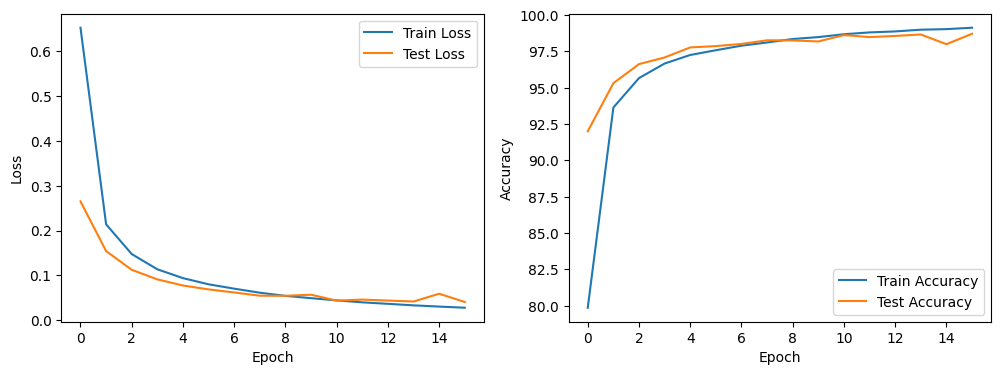

In [ ]:
# Plotting training and test errors and accuracies
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Define Decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(12, 128 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding = 1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding = 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2,output_padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 128, 4, 4)
        x = F.relu(self.deconv1(x))  # Output shape: (batch_size, 64, 8, 8)
        x = self.deconv2(x)  # Output shape: (batch_size, 32, 16, 16)
        x = F.relu(self.bn1(x))
        x = F.relu(self.deconv3(x))  # Output shape: (batch_size, 1, 28, 28))

        return x


In [ ]:
# Combine Encoder and Decoder into an Autoencoder (same as above)
class Autoencoder2(nn.Module):
    def __init__(self, Encoder):
        super(Autoencoder2, self).__init__()
        self.encoder = Encoder
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)

        x = self.decoder(x)
        return x


In [ ]:
# Freeze encoder layers
for param in ourEncoder.parameters():
    param.requires_grad = False


In [ ]:
# Model, Loss, Optimizer (same as above)
autoencoder2 = Autoencoder2(ourEncoder)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(autoencoder2.parameters(), lr=0.001)

In [ ]:
 # Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
autoencoder2.to(device)
model = autoencoder2

In [ ]:
num_epochs = 20

# Lists to store losses
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    autoencoder2.train()
    running_loss = 0.0

    for data, _ in tqdm(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        output = autoencoder2(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Evaluation
    autoencoder2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            output = autoencoder2(data)
            val_loss += criterion(output, data).item()

    test_losses.append(val_loss / len(test_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_losses[-1]:.4f}, Validation Loss: {test_losses[-1]:.4f}')



100%|██████████| 938/938 [00:11<00:00, 82.37it/s] 


Epoch [1/20], Training Loss: 0.0656, Validation Loss: 0.0622


100%|██████████| 938/938 [00:10<00:00, 93.73it/s] 


Epoch [2/20], Training Loss: 0.0618, Validation Loss: 0.0598


100%|██████████| 938/938 [00:10<00:00, 93.77it/s] 


Epoch [3/20], Training Loss: 0.0599, Validation Loss: 0.0589


100%|██████████| 938/938 [00:09<00:00, 94.88it/s]


Epoch [4/20], Training Loss: 0.0586, Validation Loss: 0.0580


100%|██████████| 938/938 [00:10<00:00, 88.08it/s]


Epoch [5/20], Training Loss: 0.0578, Validation Loss: 0.0571


100%|██████████| 938/938 [00:09<00:00, 99.79it/s]


Epoch [6/20], Training Loss: 0.0572, Validation Loss: 0.0563


100%|██████████| 938/938 [00:09<00:00, 101.70it/s]


Epoch [7/20], Training Loss: 0.0567, Validation Loss: 0.0560


100%|██████████| 938/938 [00:09<00:00, 96.16it/s] 


Epoch [8/20], Training Loss: 0.0563, Validation Loss: 0.0558


100%|██████████| 938/938 [00:09<00:00, 94.95it/s] 


Epoch [9/20], Training Loss: 0.0560, Validation Loss: 0.0557


100%|██████████| 938/938 [00:09<00:00, 94.49it/s] 


Epoch [10/20], Training Loss: 0.0557, Validation Loss: 0.0552


100%|██████████| 938/938 [00:09<00:00, 93.84it/s]


Epoch [11/20], Training Loss: 0.0555, Validation Loss: 0.0551


100%|██████████| 938/938 [00:10<00:00, 90.82it/s]


Epoch [12/20], Training Loss: 0.0553, Validation Loss: 0.0550


100%|██████████| 938/938 [00:10<00:00, 87.53it/s]


Epoch [13/20], Training Loss: 0.0551, Validation Loss: 0.0550


100%|██████████| 938/938 [00:10<00:00, 87.18it/s]


Epoch [14/20], Training Loss: 0.0550, Validation Loss: 0.0548


100%|██████████| 938/938 [00:10<00:00, 87.61it/s]


Epoch [15/20], Training Loss: 0.0548, Validation Loss: 0.0546


100%|██████████| 938/938 [00:10<00:00, 87.95it/s]


Epoch [16/20], Training Loss: 0.0546, Validation Loss: 0.0544


100%|██████████| 938/938 [00:10<00:00, 86.49it/s]


Epoch [17/20], Training Loss: 0.0545, Validation Loss: 0.0543


100%|██████████| 938/938 [00:10<00:00, 86.00it/s]


Epoch [18/20], Training Loss: 0.0544, Validation Loss: 0.0543


100%|██████████| 938/938 [00:10<00:00, 90.99it/s]


Epoch [19/20], Training Loss: 0.0543, Validation Loss: 0.0541


100%|██████████| 938/938 [00:10<00:00, 92.25it/s]


Epoch [20/20], Training Loss: 0.0542, Validation Loss: 0.0540


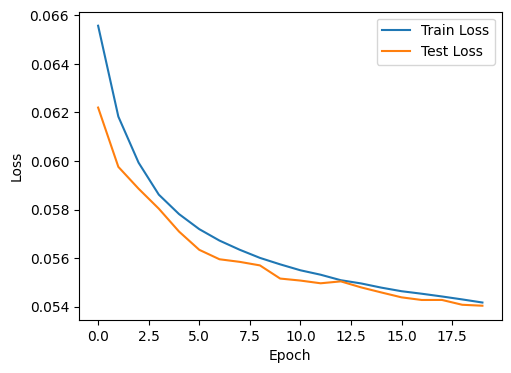

In [ ]:
# Plotting training and test losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

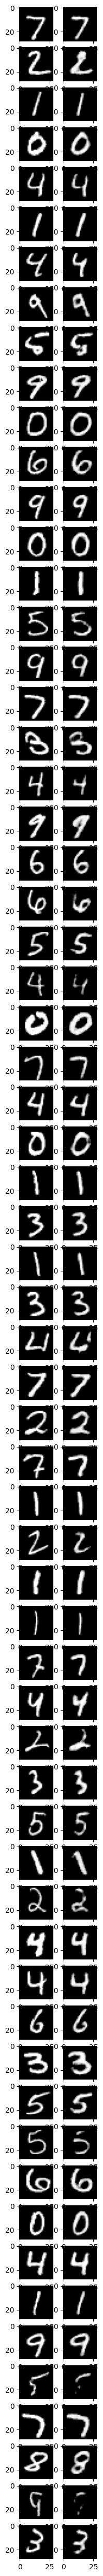

In [ ]:
# Assuming `autoencoder2` is already defined and moved to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get a batch of test data
_, (images, _) = next(enumerate(test_loader))   # Directly fetch the next batch

# Move images to GPU if available
images = images.to(device)

# Generate output from the autoencoder
with torch.no_grad():
    output = autoencoder2(images)

# Move output back to CPU if necessary for plotting
output = output.cpu()

# Plot input and output images
fig, axes = plt.subplots(64, 2, figsize=(2,64))
for i in range(64):
    axes[i, 0].imshow(images[i].squeeze().cpu().numpy(), cmap='gray')
    axes[i, 1].imshow(output[i].squeeze().numpy(), cmap='gray')

plt.show()
